In [3]:
#DNST LAYER
#Find the best number of keypoints to output
#Shuffling data
#Configuring model layout with softmax layers, Softmax useful??
#GPU optimization
#Deal with ragged tensors by creating horrid heatmaps that wont match

In [4]:
import sys
sys.path.append('dataset')
sys.path.append('loss')

import data_handler
from raggedLoss import loss_func
from environment import Variables

In [5]:
import numpy as np
from PIL import Image
from itertools import product
import matplotlib.pyplot as plt

In [6]:
dataMachine = data_handler.DataHandler()

In [7]:
img, label = dataMachine.augmentEpoch(30)

10
10
8
6
9
8
10
7
11
7
7
9
7
8
9
21
7
10
10
9
5
9
9
6
4
10
8
5
8
8


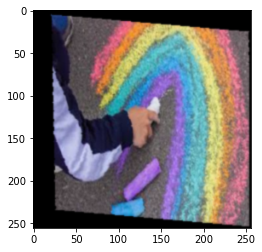

In [8]:
plt.imshow(img[1]/255.0)

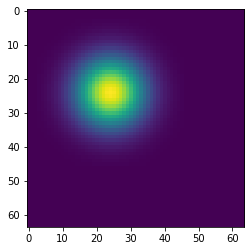

0


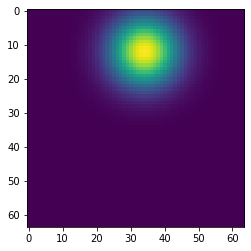

1


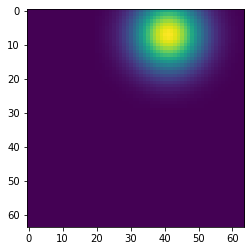

2


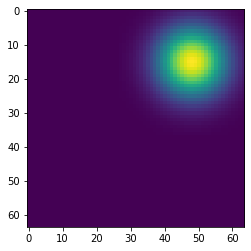

3


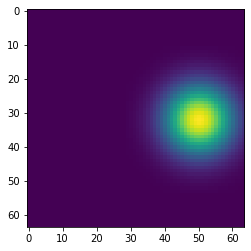

4


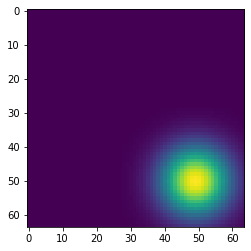

5


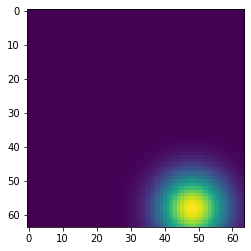

6


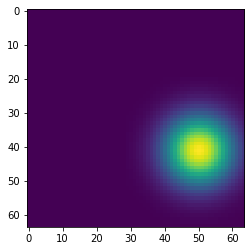

7


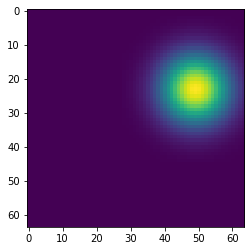

8


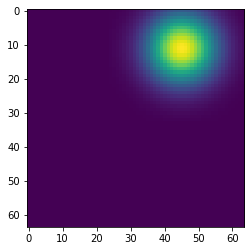

9


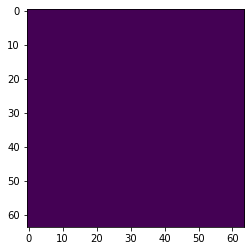

10


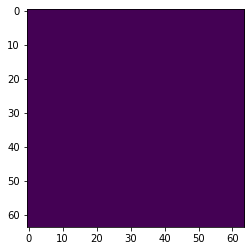

11


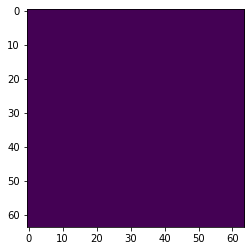

12


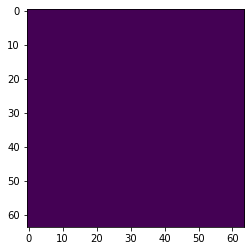

13


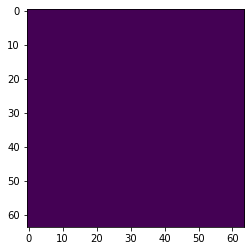

14


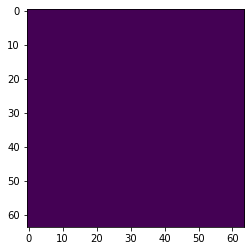

15


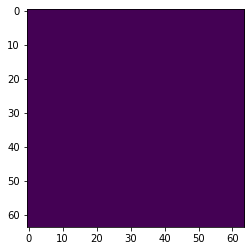

16


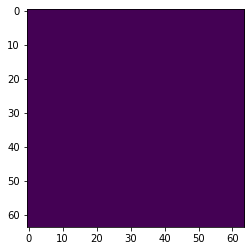

17


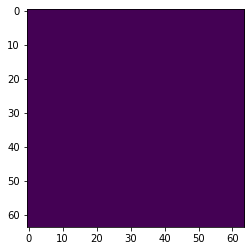

18


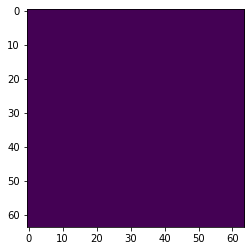

19


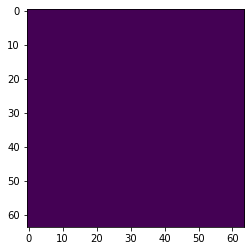

20


In [9]:
for i,x in enumerate(label[1]):
    plt.imshow(x)
    plt.show()
    print(i)

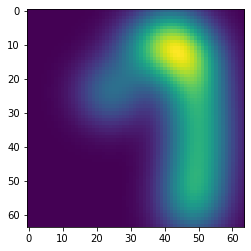

In [10]:
plt.imshow(np.sum(label[1],axis=0))

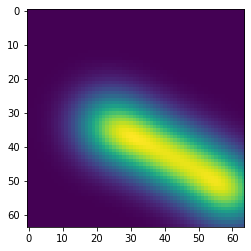

In [11]:
plt.imshow(np.sum(label[7],axis=0))

In [12]:
from keras.models import *
from keras.layers import *
import keras.backend as K
import tensorflow as tf


def create_hourglass_network(num_classes, num_stacks, num_channels, inres, outres, bottleneck):
    input = Input(shape=(inres[0], inres[1], 3))

    front_features = create_front_module(input, num_channels, bottleneck)

    head_next_stage = front_features

    outputs = []
    for i in range(num_stacks):
        head_next_stage, head_to_loss = hourglass_module(head_next_stage, num_classes, num_channels, bottleneck, i)
        outputs.append(head_to_loss)

    model = Model(inputs=input, outputs=outputs)
    return model


def hourglass_module(bottom, num_classes, num_channels, bottleneck, hgid):
    # create left features , f1, f2, f4, and f8
    left_features = create_left_half_blocks(bottom, bottleneck, hgid, num_channels)

    # create right features, connect with left features
    rf1 = create_right_half_blocks(left_features, bottleneck, hgid, num_channels)

    # add 1x1 conv with two heads, head_next_stage is sent to next stage
    # head_parts is used for intermediate supervision
    head_next_stage, head_parts = create_heads(bottom, rf1, num_classes, hgid, num_channels)

    return head_next_stage, head_parts


def bottleneck_block(bottom, num_out_channels, block_name):
    # skip layer
    if K.int_shape(bottom)[-1] == num_out_channels:
        _skip = bottom
    else:
        _skip = Conv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                       name=block_name + 'skip')(bottom)

    # residual: 3 conv blocks,  [num_out_channels/2  -> num_out_channels/2 -> num_out_channels]
    _x = Conv2D(num_out_channels / 2, kernel_size=(1, 1), activation='relu', padding='same',
                name=block_name + '_conv_1x1_x1')(bottom)
    _x = BatchNormalization()(_x)
    _x = Conv2D(num_out_channels / 2, kernel_size=(3, 3), activation='relu', padding='same',
                name=block_name + '_conv_3x3_x2')(_x)
    _x = BatchNormalization()(_x)
    _x = Conv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                name=block_name + '_conv_1x1_x3')(_x)
    _x = BatchNormalization()(_x)
    _x = Add(name=block_name + '_residual')([_skip, _x])

    return _x


def bottleneck_mobile(bottom, num_out_channels, block_name):
    # skip layer
    if K.int_shape(bottom)[-1] == num_out_channels:
        _skip = bottom
    else:
        _skip = SeparableConv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                                name=block_name + 'skip')(bottom)

    # residual: 3 conv blocks,  [num_out_channels/2  -> num_out_channels/2 -> num_out_channels]
    _x = SeparableConv2D(num_out_channels / 2, kernel_size=(1, 1), activation='relu', padding='same',
                         name=block_name + '_conv_1x1_x1')(bottom)
    _x = BatchNormalization()(_x)
    _x = SeparableConv2D(num_out_channels / 2, kernel_size=(3, 3), activation='relu', padding='same',
                         name=block_name + '_conv_3x3_x2')(_x)
    _x = BatchNormalization()(_x)
    _x = SeparableConv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                         name=block_name + '_conv_1x1_x3')(_x)
    _x = BatchNormalization()(_x)
    _x = Add(name=block_name + '_residual')([_skip, _x])

    return _x


def create_front_module(input, num_channels, bottleneck):
    # front module, input to 1/4 resolution
    # 1 7x7 conv + maxpooling
    # 3 residual block

    _x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu', name='front_conv_1x1_x1')(
        input)
    _x = BatchNormalization()(_x)

    _x = bottleneck(_x, num_channels // 2, 'front_residual_x1')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(_x)

    _x = bottleneck(_x, num_channels // 2, 'front_residual_x2')
    _x = bottleneck(_x, num_channels, 'front_residual_x3')

    return _x


def create_left_half_blocks(bottom, bottleneck, hglayer, num_channels):
    # create left half blocks for hourglass module
    # f1, f2, f4 , f8 : 1, 1/2, 1/4 1/8 resolution

    hgname = 'hg' + str(hglayer)

    f1 = bottleneck(bottom, num_channels, hgname + '_l1')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f1)

    f2 = bottleneck(_x, num_channels, hgname + '_l2')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f2)

    f4 = bottleneck(_x, num_channels, hgname + '_l4')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f4)

    f8 = bottleneck(_x, num_channels, hgname + '_l8')

    return (f1, f2, f4, f8)


def connect_left_to_right(left, right, bottleneck, name, num_channels):
    '''
    :param left: connect left feature to right feature
    :param name: layer name
    :return:
    '''
    # left -> 1 bottlenect
    # right -> upsampling
    # Add   -> left + right

    _xleft = bottleneck(left, num_channels, name + '_connect')
    _xright = UpSampling2D()(right)
    add = Add()([_xleft, _xright])
    out = bottleneck(add, num_channels, name + '_connect_conv')
    return out


def bottom_layer(lf8, bottleneck, hgid, num_channels):
    # blocks in lowest resolution
    # 3 bottlenect blocks + Add

    lf8_connect = bottleneck(lf8, num_channels, str(hgid) + "_lf8")

    _x = bottleneck(lf8, num_channels, str(hgid) + "_lf8_x1")
    _x = bottleneck(_x, num_channels, str(hgid) + "_lf8_x2")
    _x = bottleneck(_x, num_channels, str(hgid) + "_lf8_x3")

    rf8 = Add()([_x, lf8_connect])

    return rf8


def create_right_half_blocks(leftfeatures, bottleneck, hglayer, num_channels):
    lf1, lf2, lf4, lf8 = leftfeatures

    rf8 = bottom_layer(lf8, bottleneck, hglayer, num_channels)

    rf4 = connect_left_to_right(lf4, rf8, bottleneck, 'hg' + str(hglayer) + '_rf4', num_channels)

    rf2 = connect_left_to_right(lf2, rf4, bottleneck, 'hg' + str(hglayer) + '_rf2', num_channels)

    rf1 = connect_left_to_right(lf1, rf2, bottleneck, 'hg' + str(hglayer) + '_rf1', num_channels)

    return rf1


def create_heads(prelayerfeatures, rf1, num_classes, hgid, num_channels):
    # two head, one head to next stage, one head to intermediate features
    head = Conv2D(num_channels, kernel_size=(1, 1), activation='relu', padding='same', name=str(hgid) + '_conv_1x1_x1')(
        rf1)
    head = BatchNormalization()(head)

    head_parts = Conv2D(num_classes, kernel_size=(1, 1), activation='linear', padding='same',
                        name=str(hgid) + '_conv_1x1_parts')(head)

    # for head as intermediate supervision, use 'linear' as activation.
    head_parts = Conv2D(num_classes, kernel_size=(1, 1), activation='softmax', padding='same', name=str(hgid) + '_conv_1x1_parts_softmax')(head_parts)

    # use linear activation
    head = Conv2D(num_channels, kernel_size=(1, 1), activation='linear', padding='same',
                  name=str(hgid) + '_conv_1x1_x2')(head)
    head_m = Conv2D(num_channels, kernel_size=(1, 1), activation='linear', padding='same',
                    name=str(hgid) + '_conv_1x1_x3')(head_parts)

    head_next_stage = Add()([head, head_m, prelayerfeatures])
    return head_next_stage, head_parts

In [17]:
tf.config.run_functions_eagerly(True)

In [18]:
model = create_hourglass_network(7, 4, 256, Variables.INP_SIZE, Variables.OUT_SIZE, bottleneck = bottleneck_block)

In [19]:
model.compile(optimizer="Adam", loss=loss_func)

In [20]:
data = dataMachine.augmentEpoch(30)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
# data = dataMachine.augmentEpoch(300)
# model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
# data = dataMachine.augmentEpoch(300)
# model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
# data = dataMachine.augmentEpoch(300)
# model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
# data = dataMachine.augmentEpoch(300)
# model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
# data = dataMachine.augmentEpoch(300)
# model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
# data = dataMachine.augmentEpoch(300)
# model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)

10
10
8
6
9
8
10
7
11
7
7
9
7
8
9
21
7
10
10
9
5
9
9
6
4
10
8
5
8
8
Epoch 1/2


2024-08-22 22:22:38.255477: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2024-08-22 22:22:38.495340: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-08-22 22:22:48.801322: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 20.00MiB (rounded to 20971520)requested by op AddV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-08-22 22:22:48.801388: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-08-22 22:22:48.801395: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 137, Chunks in use: 137. 34.2KiB allocated for chunks. 34.2KiB in use in bin. 20.1KiB clien

ResourceExhaustedError: Exception encountered when calling layer 'add_23' (type Add).

{{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:AddV2] name: 

Call arguments received by layer 'add_23' (type Add):
  • inputs=['tf.Tensor(shape=(5, 64, 64, 256), dtype=float32)', 'tf.Tensor(shape=(5, 64, 64, 256), dtype=float32)']

-22 22:22:48.843603: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7f99f6e0db00 of size 1024 next 2396
2024-08-22 22:22:48.843606: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7f99f6e0df00 of size 1024 next 2397
2024-08-22 22:22:48.843795: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7f99f6e0e300 of size 1024 next 2398
2024-08-22 22:22:48.843799: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7f99f6e0e700 of size 512 next 2403
2024-08-22 22:22:48.843801: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7f99f6e0e900 of size 512 next 2404
2024-08-22 22:22:48.843803: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7f99f6e0eb00 of size 512 next 2405
2024-08-22 22:22:48.843806: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7f99f6e0ed00 of size 512 next 2406
2024-08-22 22:22:48.843808: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7f99f6e0ef00 of size 512 next 2409
2024-08-22 22:22:48.843810: 

In [ ]:
out = model.predict(data[0])

In [ ]:
np.shape(out)

In [ ]:
np.sum(np.transpose(out[3][0],(2,0,1)),axis=0)

0.087227404


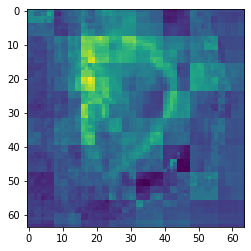

0.08366412


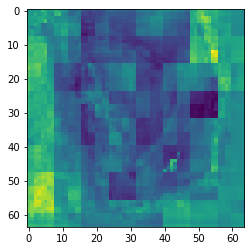

0.07733818


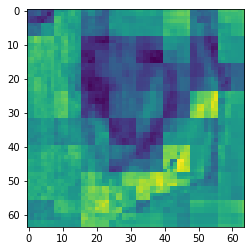

0.0788677


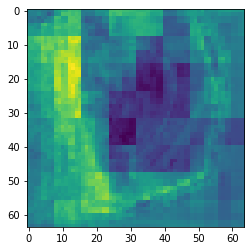

0.035214044


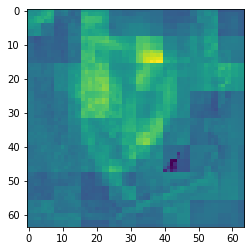

0.07365183


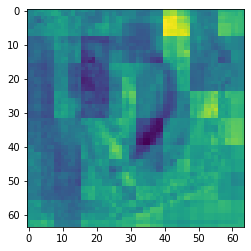

0.09617882


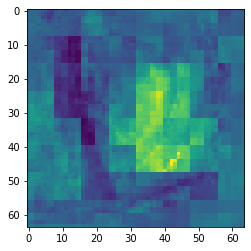

In [18]:
for x in np.transpose(out[0][0],(2,0,1)):
    print(np.min(x))
    plt.imshow(x)
    plt.show()

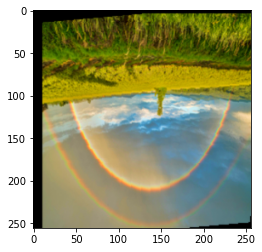

In [50]:
plt.imshow(data[0][0]/255.0)

In [104]:
gah = Image.open('brrrr.jpg')

In [105]:
gah = gah.resize((256,256))

In [106]:
out = model.predict(np.expand_dims(np.array(gah), axis=0))

1/1 [==============================] - 0s 247ms/step


In [107]:
np.shape(out)

(4, 1, 64, 64, 7)

0.005526531


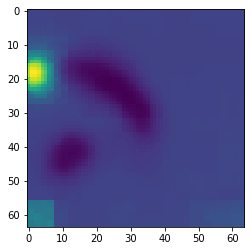

0.004737408


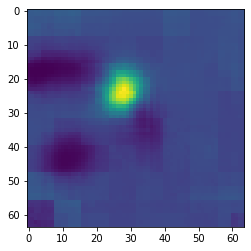

0.015574261


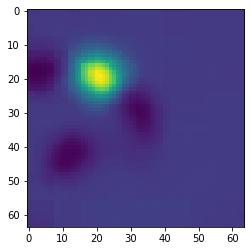

0.011428473


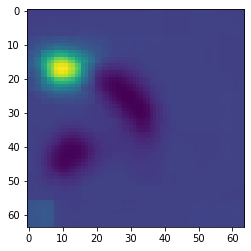

0.0055831005


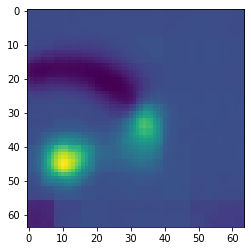

0.0073060193


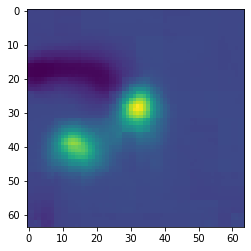

0.003621494


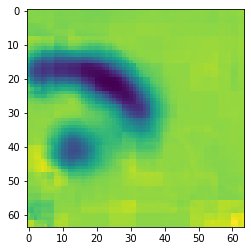

In [108]:
for x in np.transpose(out[3][0],(2,0,1)):
    print(np.min(x))
    plt.imshow(x)
    plt.show()

In [109]:
from scipy.ndimage import zoom

# Example: 2D array
array = np.array([[1, 2], [3, 4]])

# Upsample by a scale factor of 2
scale_factor = 2
upsampled_array = zoom(array, scale_factor, order=1)  # order=1 for bilinear interpolation

print(upsampled_array)

[[1 1 2 2]
 [2 2 2 3]
 [2 3 3 3]
 [3 3 4 4]]


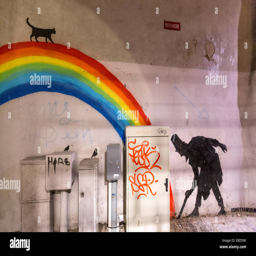

In [110]:
gah

In [ ]:
model.summary()

In [ ]:
#DNST LAYER
#Find the best number of keypoints to output
#Shuffling data
#Configuring model layout with softmax layers, Softmax useful??
#GPU optimization

In [1]:
import sys
sys.path.append('dataset')
sys.path.append('loss')

import data_handler
from newLoss import loss_func
from environment import Variables

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import numpy as np
from PIL import Image
from itertools import product
import matplotlib.pyplot as plt

In [3]:
dataMachine = data_handler.DataHandler()

In [4]:
img, label = dataMachine.augmentEpoch(30)

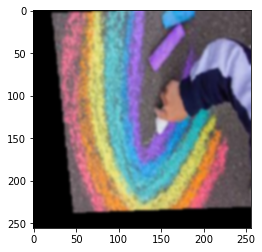

In [5]:
plt.imshow(img[1]/255.0)

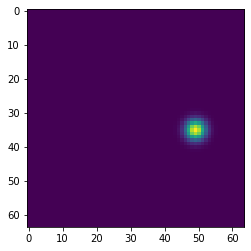

0


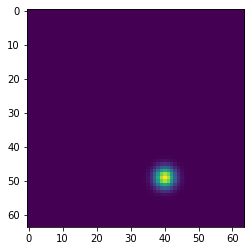

1


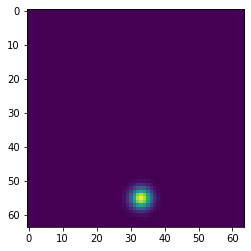

2


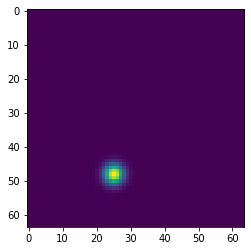

3


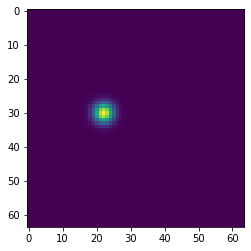

4


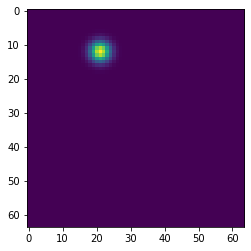

5


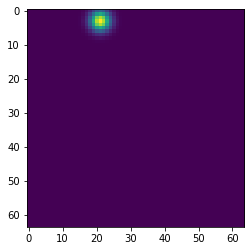

6


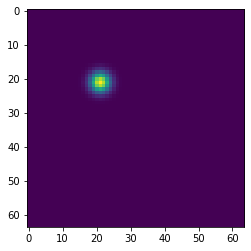

7


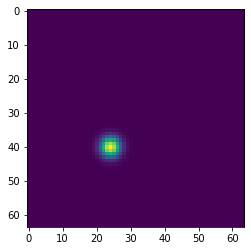

8


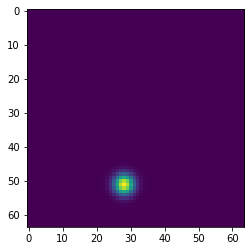

9


In [6]:
for i,x in enumerate(label[1]):
    plt.imshow(x)
    plt.show()
    print(i)

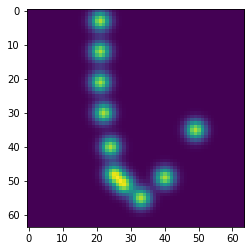

In [7]:
plt.imshow(np.sum(label[1],axis=0))

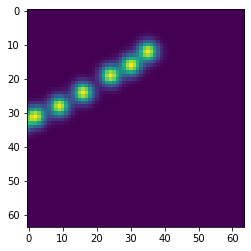

In [8]:
plt.imshow(np.sum(label[7],axis=0))

In [37]:
from keras.models import *
from keras.layers import *
import keras.backend as K
import tensorflow as tf


def create_hourglass_network(num_classes, num_stacks, num_channels, inres, outres, bottleneck):
    input = Input(shape=(inres[0], inres[1], 3))

    front_features = create_front_module(input, num_channels, bottleneck)

    head_next_stage = front_features

    outputs = []
    for i in range(num_stacks):
        head_next_stage, head_to_loss = hourglass_module(head_next_stage, num_classes, num_channels, bottleneck, i)
        outputs.append(head_to_loss)

    model = Model(inputs=input, outputs=outputs)
    return model


def hourglass_module(bottom, num_classes, num_channels, bottleneck, hgid):
    # create left features , f1, f2, f4, and f8
    left_features = create_left_half_blocks(bottom, bottleneck, hgid, num_channels)

    # create right features, connect with left features
    rf1 = create_right_half_blocks(left_features, bottleneck, hgid, num_channels)

    # add 1x1 conv with two heads, head_next_stage is sent to next stage
    # head_parts is used for intermediate supervision
    head_next_stage, head_parts = create_heads(bottom, rf1, num_classes, hgid, num_channels)

    return head_next_stage, head_parts


def bottleneck_block(bottom, num_out_channels, block_name):
    # skip layer
    if K.int_shape(bottom)[-1] == num_out_channels:
        _skip = bottom
    else:
        _skip = Conv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                       name=block_name + 'skip')(bottom)

    # residual: 3 conv blocks,  [num_out_channels/2  -> num_out_channels/2 -> num_out_channels]
    _x = Conv2D(num_out_channels / 2, kernel_size=(1, 1), activation='relu', padding='same',
                name=block_name + '_conv_1x1_x1')(bottom)
    _x = BatchNormalization()(_x)
    _x = Conv2D(num_out_channels / 2, kernel_size=(3, 3), activation='relu', padding='same',
                name=block_name + '_conv_3x3_x2')(_x)
    _x = BatchNormalization()(_x)
    _x = Conv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                name=block_name + '_conv_1x1_x3')(_x)
    _x = BatchNormalization()(_x)
    _x = Add(name=block_name + '_residual')([_skip, _x])

    return _x


def bottleneck_mobile(bottom, num_out_channels, block_name):
    # skip layer
    if K.int_shape(bottom)[-1] == num_out_channels:
        _skip = bottom
    else:
        _skip = SeparableConv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                                name=block_name + 'skip')(bottom)

    # residual: 3 conv blocks,  [num_out_channels/2  -> num_out_channels/2 -> num_out_channels]
    _x = SeparableConv2D(num_out_channels / 2, kernel_size=(1, 1), activation='relu', padding='same',
                         name=block_name + '_conv_1x1_x1')(bottom)
    _x = BatchNormalization()(_x)
    _x = SeparableConv2D(num_out_channels / 2, kernel_size=(3, 3), activation='relu', padding='same',
                         name=block_name + '_conv_3x3_x2')(_x)
    _x = BatchNormalization()(_x)
    _x = SeparableConv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                         name=block_name + '_conv_1x1_x3')(_x)
    _x = BatchNormalization()(_x)
    _x = Add(name=block_name + '_residual')([_skip, _x])

    return _x


def create_front_module(input, num_channels, bottleneck):
    # front module, input to 1/4 resolution
    # 1 7x7 conv + maxpooling
    # 3 residual block

    _x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu', name='front_conv_1x1_x1')(
        input)
    _x = BatchNormalization()(_x)

    _x = bottleneck(_x, num_channels // 2, 'front_residual_x1')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(_x)

    _x = bottleneck(_x, num_channels // 2, 'front_residual_x2')
    _x = bottleneck(_x, num_channels, 'front_residual_x3')

    return _x


def create_left_half_blocks(bottom, bottleneck, hglayer, num_channels):
    # create left half blocks for hourglass module
    # f1, f2, f4 , f8 : 1, 1/2, 1/4 1/8 resolution

    hgname = 'hg' + str(hglayer)

    f1 = bottleneck(bottom, num_channels, hgname + '_l1')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f1)

    f2 = bottleneck(_x, num_channels, hgname + '_l2')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f2)

    f4 = bottleneck(_x, num_channels, hgname + '_l4')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f4)

    f8 = bottleneck(_x, num_channels, hgname + '_l8')

    return (f1, f2, f4, f8)


def connect_left_to_right(left, right, bottleneck, name, num_channels):
    '''
    :param left: connect left feature to right feature
    :param name: layer name
    :return:
    '''
    # left -> 1 bottlenect
    # right -> upsampling
    # Add   -> left + right

    _xleft = bottleneck(left, num_channels, name + '_connect')
    _xright = UpSampling2D()(right)
    add = Add()([_xleft, _xright])
    out = bottleneck(add, num_channels, name + '_connect_conv')
    return out


def bottom_layer(lf8, bottleneck, hgid, num_channels):
    # blocks in lowest resolution
    # 3 bottlenect blocks + Add

    lf8_connect = bottleneck(lf8, num_channels, str(hgid) + "_lf8")

    _x = bottleneck(lf8, num_channels, str(hgid) + "_lf8_x1")
    _x = bottleneck(_x, num_channels, str(hgid) + "_lf8_x2")
    _x = bottleneck(_x, num_channels, str(hgid) + "_lf8_x3")

    rf8 = Add()([_x, lf8_connect])

    return rf8


def create_right_half_blocks(leftfeatures, bottleneck, hglayer, num_channels):
    lf1, lf2, lf4, lf8 = leftfeatures

    rf8 = bottom_layer(lf8, bottleneck, hglayer, num_channels)

    rf4 = connect_left_to_right(lf4, rf8, bottleneck, 'hg' + str(hglayer) + '_rf4', num_channels)

    rf2 = connect_left_to_right(lf2, rf4, bottleneck, 'hg' + str(hglayer) + '_rf2', num_channels)

    rf1 = connect_left_to_right(lf1, rf2, bottleneck, 'hg' + str(hglayer) + '_rf1', num_channels)

    return rf1


def create_heads(prelayerfeatures, rf1, num_classes, hgid, num_channels):
    # two head, one head to next stage, one head to intermediate features
    head = Conv2D(num_channels, kernel_size=(1, 1), activation='relu', padding='same', name=str(hgid) + '_conv_1x1_x1')(
        rf1)
    head = BatchNormalization()(head)

    head_parts = Conv2D(num_classes, kernel_size=(1, 1), activation='linear', padding='same',
                        name=str(hgid) + '_conv_1x1_parts')(head)

    # for head as intermediate supervision, use 'linear' as activation.
    # head_parts = Conv2D(num_classes, kernel_size=(1, 1), activation='softmax', padding='same', name=str(hgid) + '_conv_1x1_parts_softmax')(head_parts)

    # use linear activation
    head = Conv2D(num_channels, kernel_size=(1, 1), activation='linear', padding='same',
                  name=str(hgid) + '_conv_1x1_x2')(head)
    head_m = Conv2D(num_channels, kernel_size=(1, 1), activation='linear', padding='same',
                    name=str(hgid) + '_conv_1x1_x3')(head_parts)

    head_next_stage = Add()([head, head_m, prelayerfeatures])
    return head_next_stage, head_parts

In [38]:
tf.config.run_functions_eagerly(True)

In [39]:
model = create_hourglass_network(12, 4, 256, Variables.INP_SIZE, Variables.OUT_SIZE, bottleneck = bottleneck_block)

In [40]:
model.compile(optimizer="Adam", loss=loss_func)

In [ ]:
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)

In [24]:
out = model.predict(data[0])

10/10 [==============================] - 2s 229ms/step


In [25]:
np.shape(out)

(4, 300, 64, 64, 12)

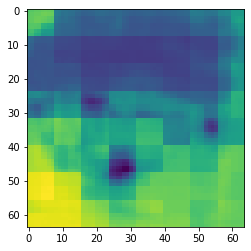

In [26]:
plt.imshow(np.sum(np.transpose(out[3][0],(2,0,1))[0:7],axis=0))

0.0042609787


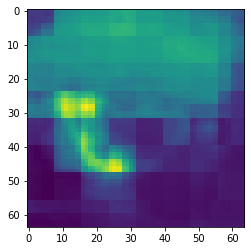

0.018625474


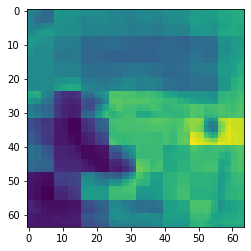

0.003564904


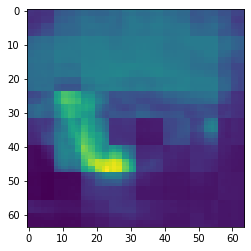

0.00058319094


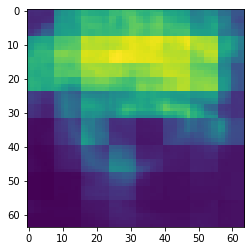

0.0023697943


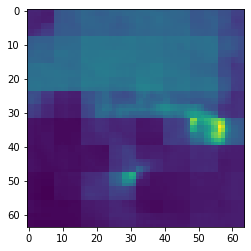

0.031174866


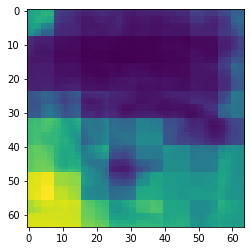

0.0022596146


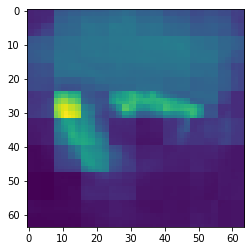

0.005172058


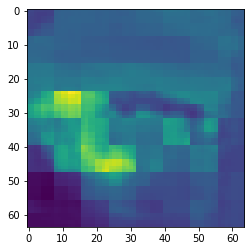

0.0013132769


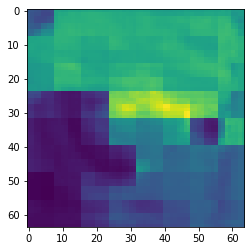

0.0035540778


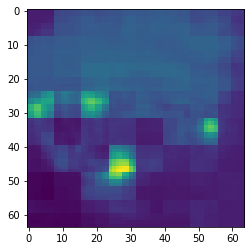

0.0017217919


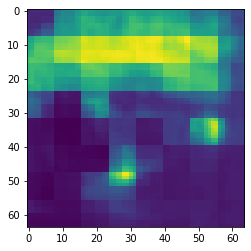

0.0019383262


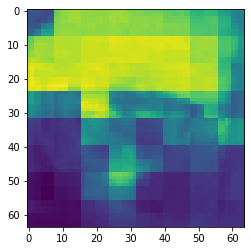

In [27]:
for x in np.transpose(out[3][0],(2,0,1)):
    print(np.min(x))
    plt.imshow(x)
    plt.show()

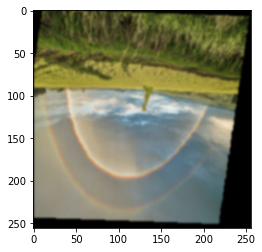

In [28]:
plt.imshow(data[0][0]/255.0)

In [104]:
gah = Image.open('brrrr.jpg')

In [105]:
gah = gah.resize((256,256))

In [106]:
out = model.predict(np.expand_dims(np.array(gah), axis=0))

1/1 [==============================] - 0s 247ms/step


In [107]:
np.shape(out)

(4, 1, 64, 64, 7)

0.005526531


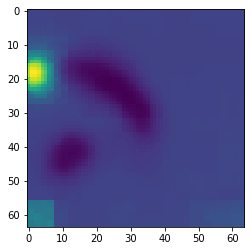

0.004737408


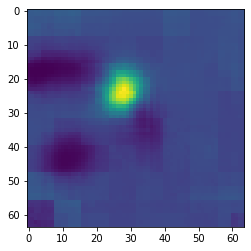

0.015574261


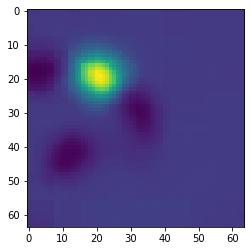

0.011428473


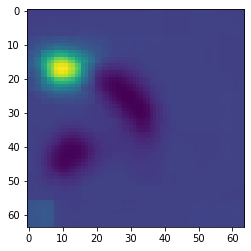

0.0055831005


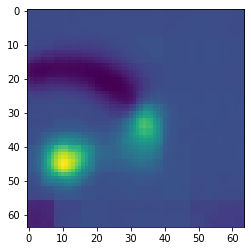

0.0073060193


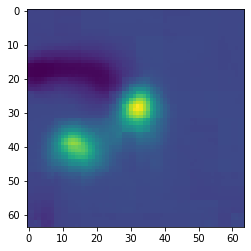

0.003621494


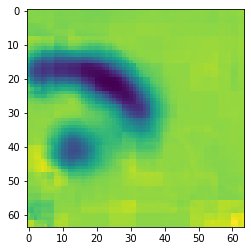

In [108]:
for x in np.transpose(out[3][0],(2,0,1)):
    print(np.min(x))
    plt.imshow(x)
    plt.show()

In [109]:
from scipy.ndimage import zoom

# Example: 2D array
array = np.array([[1, 2], [3, 4]])

# Upsample by a scale factor of 2
scale_factor = 2
upsampled_array = zoom(array, scale_factor, order=1)  # order=1 for bilinear interpolation

print(upsampled_array)

[[1 1 2 2]
 [2 2 2 3]
 [2 3 3 3]
 [3 3 4 4]]


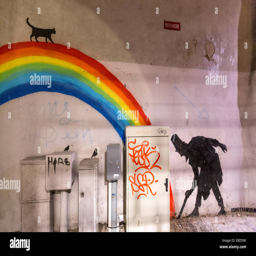

In [110]:
gah

In [ ]:
model.summary()